This is the notebook for determining the overhead added by parameter control

It is divided into the main paragraphs:

- Data Preperation
- Model specification and execution

# Data Preperation


In [1]:
import formulaic
import pymc as pm
import pandas as pd

data = pd.read_csv("../single_parameter/combined_data/statistics.csv")


# Dummy variables for Module and Parameters
model_formula = 'AlgorithmIterations ~ 0 + C(TargetModule) + C(TuningParameters, contr.treatment("NONE"))'
design_matrix = formulaic.model_matrix(model_formula, data=data)

module_matrix = design_matrix.rhs.iloc[:, :24]
parameter_matrix = design_matrix.rhs.iloc[:, 24:]

# Dummy variables for interaction terms
model_formula = 'AlgorithmIterations ~ 0 + C(TargetModule) : C(TuningParameters)'
design_matrix = formulaic.model_matrix(model_formula, data=data)

# Filter out columns that contain 'T.NONE' in their name
columns_to_drop = [col for col in design_matrix.rhs.columns if 'T.NONE' in col]

# Drop the identified columns
design_matrix.rhs.drop(columns=columns_to_drop, axis=1, inplace=True)
interaction_matrix = design_matrix.rhs.iloc[:,:]
#design_matrix.lhs.describe()


# Model Specification

In [ ]:
with pm.Model() as model:
    # Global Intercept and standard deviation for Modules
    a_bar = pm.Normal('a_bar', mu=7, sigma=0.5)
    
    # Standard Deviations for modules, parameters and interactions
    sigma_a = pm.Exponential('sigma_a', 4.0)
    sigma_b = pm.Exponential('sigma_b', 4.0)
    sigma_g = pm.Exponential('sigma_g', 4.0)
    
    # Non-centered parameterizations for module, parameter and interaction effect.
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=12)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    g_offset = pm.Normal('g_offset', mu=0, sigma=1, shape=288)
    g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)

    
    # Activate the correct dummy variables
    log_a = pm.math.dot(module_matrix, a_m)
    log_b = pm.math.dot(parameter_matrix, b_p)
    log_g = pm.math.dot(interaction_matrix, g_mp)

    # Link function (log)
    mu = pm.Deterministic('mu', pm.math.exp(log_a + log_b + log_g))
    
    # Negative Binomial likelihood
    theta = pm.Uniform('theta', 5, 100) # dispersion parameter
    Y_obs = pm.NegativeBinomial('Y_obs', n=theta, p=(theta)/(mu + theta), observed=design_matrix.lhs['AlgorithmIterations'])
    
    # Sample from the model
    trace = pm.sample(1000, chains=4,return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)
    
print("Model building complete.")

### Save the results

In [ ]:
import arviz as az

az.to_netcdf(trace, "overhead_model_trace_single_param.nc")

In [4]:
import arviz as az
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp


# Example usage
trace = az.from_netcdf("model_overhead_trace.nc")
variable_list = ['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p']
transformations = {
    #'a_m': log_to_exp,
    #'a_bar': log_to_exp,
    #'sigma_a': log_to_exp
    #'b_p': log_to_exp
}

idata = create_inference_data_from_trace(trace, variable_list, transformations)
table = az.summary(idata, ['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p'], hdi_prob=0.89)
table

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_m[0],7.166,0.011,7.147,7.183,0.000,0.000,3117.0,2933.0,1.00
a_m[1],7.429,0.011,7.410,7.446,0.000,0.000,3293.0,2954.0,1.00
a_m[2],7.255,0.011,7.237,7.273,0.000,0.000,4019.0,3233.0,1.00
a_m[3],7.319,0.011,7.302,7.337,0.000,0.000,4034.0,3406.0,1.00
a_m[4],7.134,0.011,7.116,7.152,0.000,0.000,3962.0,3377.0,1.00
a_m[5],7.649,0.011,7.631,7.667,0.000,0.000,3582.0,2782.0,1.00
a_m[6],7.437,0.011,7.419,7.455,0.000,0.000,3758.0,3040.0,1.00
a_m[7],6.431,0.012,6.414,6.451,0.000,0.000,3720.0,3627.0,1.00
a_m[8],7.005,0.011,6.986,7.022,0.000,0.000,3611.0,3085.0,1.00
a_m[9],6.910,0.011,6.893,6.929,0.000,0.000,4016.0,3379.0,1.00


array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>]],
      dtype=object)

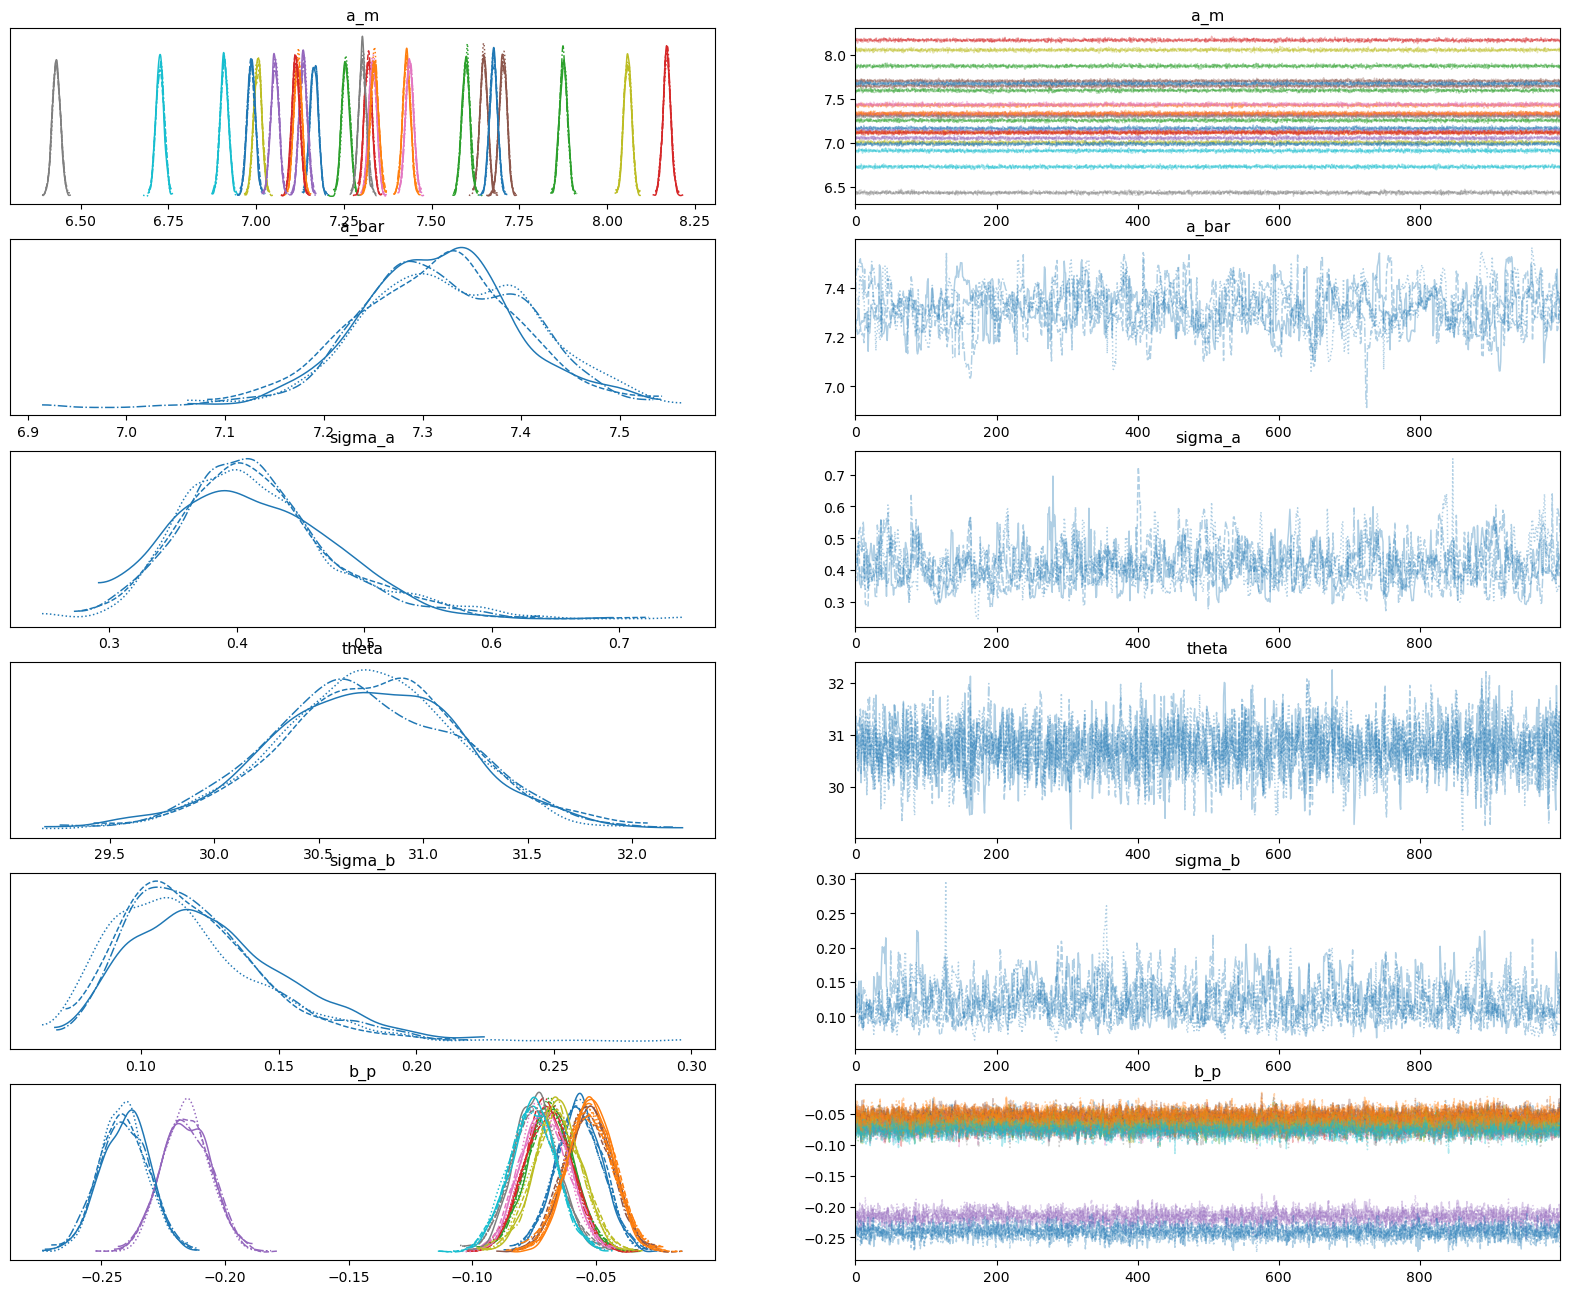

In [5]:
az.plot_trace(idata, var_names=['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p'], figsize=(20, 16))

Sampling: [a_bar, a_offset, b_offset, g_offset, sigma_a, sigma_b, sigma_g, theta]


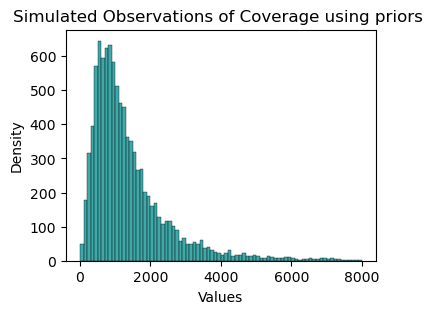

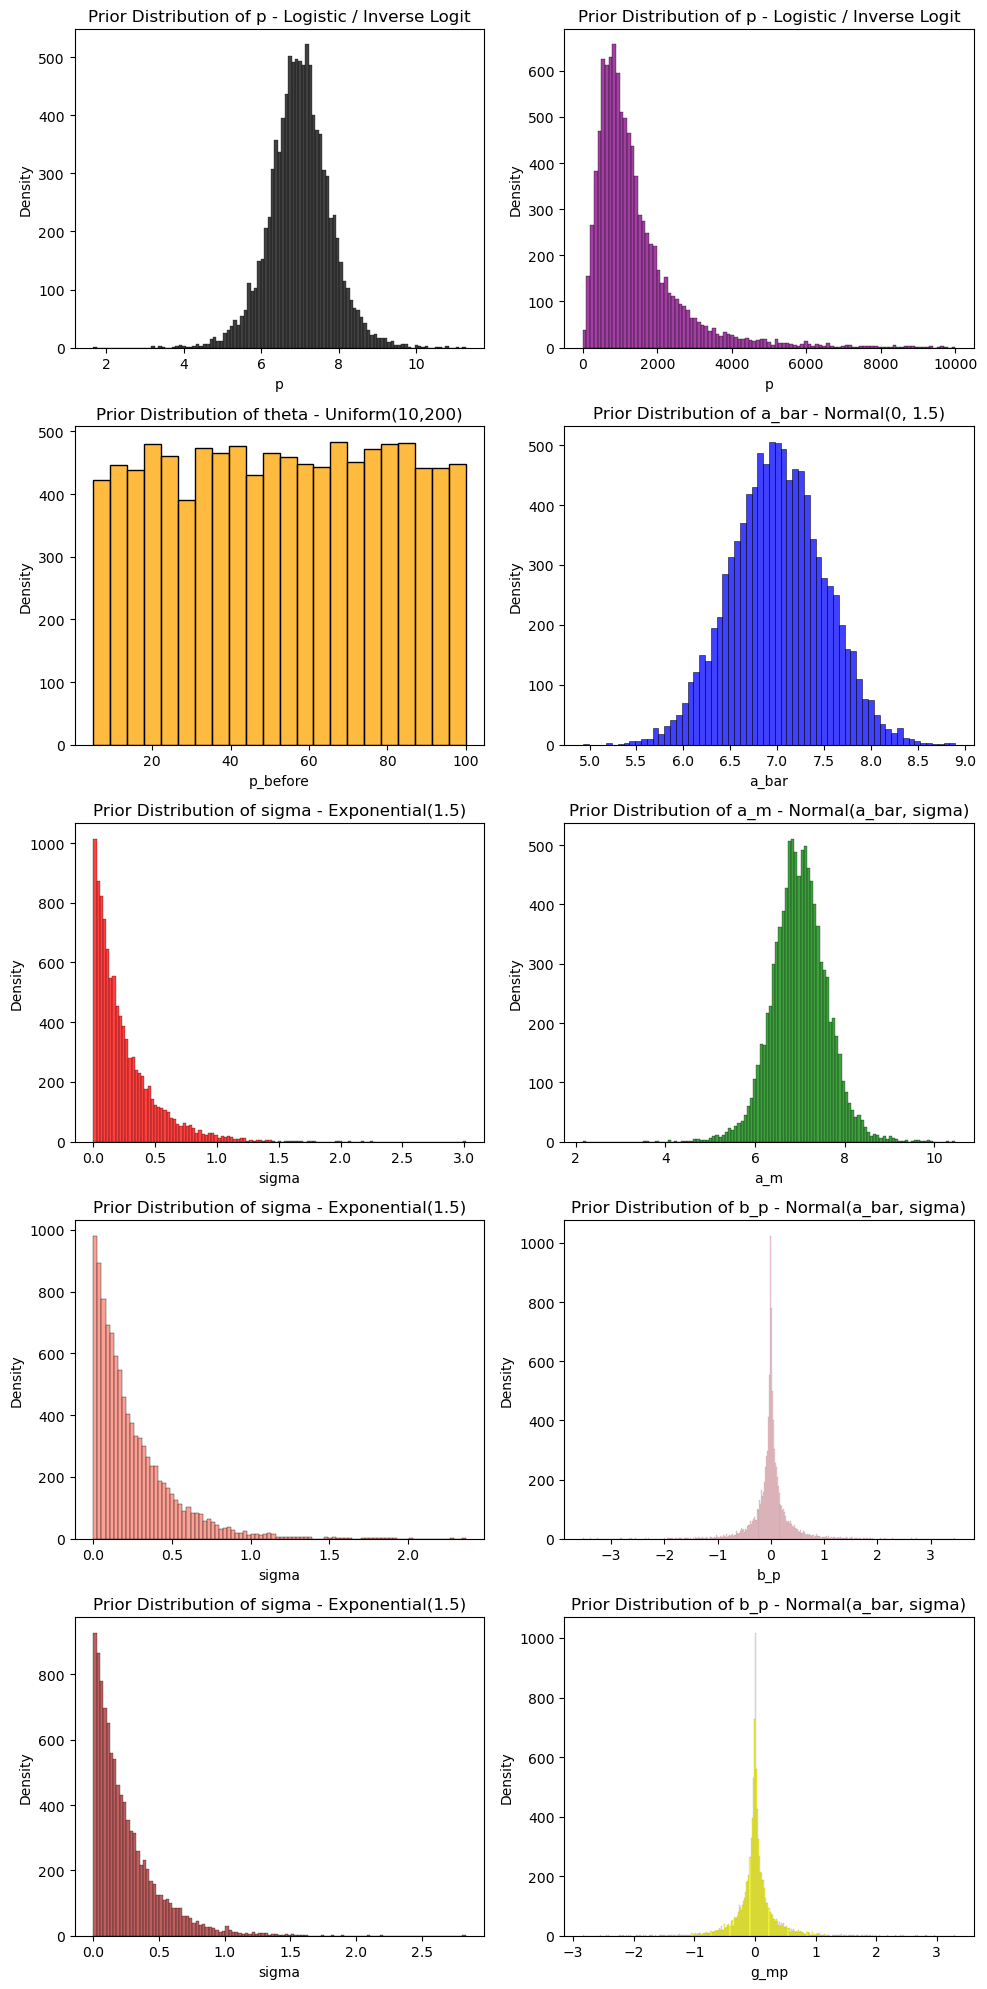

In [3]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def calc_prior_dist(s_a, s_b, s_g, a_bar_mu, a_bar_sigma):
    with pm.Model():
        # Global Intercept and standard deviation for Modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard Deviations for Modules, Parameters and Interactions
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        sigma_g = pm.Exponential('sigma_g', s_g)
        
        # Non-centered parameterizations
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)

        g_offset = pm.Normal('g_offset', mu=0, sigma=1)
        g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)


        # Link function (logit), unbounded to (0,1) probability
        pm.Deterministic('mu_before', a_m + b_p + g_mp)
        pm.Deterministic('mu', pm.math.exp(a_m + b_p + g_mp))
        
        # Beta distribution likelihood 
        pm.Uniform('theta', 5, 100)
        
        # Sample from the model
        idata = pm.sample_prior_predictive(samples=10000)



    # Fetch and flatten priors
    prior_mu= idata.prior['mu'].values.flatten()
    prior_theta = idata.prior['theta'].values.flatten()

    simulated_observations = np.random.negative_binomial(n=prior_theta, p=(prior_theta)/(prior_mu + prior_theta))
    
    #Predicated observations
    plt.figure(figsize=(4, 3))

    observation_plot = HistogramPlot(simulated_observations,'Simulated Observations of Coverage using priors ', 'Values',
                                     'darkcyan', bin_range=(0,8000))
    observation_plot.plot()


    plots = [
        HistogramPlot(idata.prior['mu_before'].values.flatten(), 'Prior Distribution of p - Logistic / Inverse Logit', 'p', 'black'),
        HistogramPlot(idata.prior['mu'].values.flatten(), 'Prior Distribution of p - Logistic / Inverse Logit', 'p', 'purple', bin_range=(0, 10000)),
        HistogramPlot(idata.prior['theta'].values.flatten(), 'Prior Distribution of theta - Uniform(10,200)', 'p_before', 'orange'),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior Distribution of a_bar - Normal(0, 1.5)', 'a_bar', 'blue'),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'red'),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior Distribution of a_m - Normal(a_bar, sigma)', 'a_m', 'green'),
        HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'salmon'),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior Distribution of b_p - Normal(a_bar, sigma)', 'b_p', 'pink'),
        HistogramPlot(idata.prior['sigma_g'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'brown'),
        HistogramPlot(idata.prior['g_mp'].values.flatten(), 'Prior Distribution of b_p - Normal(a_bar, sigma)', 'g_mp', 'yellow')
    ]

    plot_histograms(plots, 5, 2, figsize=(10,20))


s_a = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_alpha (sigma_a):')
s_b = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_beta (sigma_b):')
s_g = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_gamma (sigma_g):')
a_bar_mu = FloatSlider(value=7, min=0, max=10, step=0.1, description='alpha bar mu (a_bar_mu):')
a_bar_sigma = FloatSlider(value=0.5, min=0, max=3, step=0.1, description='alpha bar sigma (a_bar_sigma):')



#interact(calc_prior_dist, s_a=s_a, s_b=s_b, s_g=s_g, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma)
calc_prior_dist(4,4,4,7,0.5)